In [2]:
# Import necessary libraries for data analysis, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline  

In [3]:
try:
    data = pd.read_csv('Bengaluru_House_Data.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: Bengaluru_House_Data.csv not found. Download from: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data")

Dataset loaded successfully!


In [4]:
# Display first 5 rows
print("\nFirst 5 rows of the dataset:")
display(data.head())


First 5 rows of the dataset:


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
# Dataset info
print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB
None


In [6]:
# Check missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64


In [7]:
# Handle missing values
data['size'] = data['size'].fillna(data['size'].mode()[0])  # Fill with mode
data['society'] = data['society'].fillna('Unknown')  # Fill with 'Unknown'
data['bath'] = data['bath'].fillna(data['bath'].median())  # Fill with median
data['balcony'] = data['balcony'].fillna(data['balcony'].median())  # Fill with median
data['location'] = data['location'].fillna(data['location'].mode()[0])

In [8]:
# Convert 'size' to numerical BHK
def convert_size(size):
    try:
        if 'BHK' in str(size):
            return int(size.split(' ')[0])
        elif 'Bedroom' in str(size):
            return int(size.split(' ')[0])
        else:
            return np.nan
    except:
        return np.nan

data['bhk'] = data['size'].apply(convert_size)

In [9]:
# Clean 'total_sqft' (handle ranges like '1133 - 1384')
def convert_sqft(sqft):
    try:
        if '-' in str(sqft):
            start, end = map(float, sqft.split('-'))
            return (start + end) / 2
        return float(sqft)
    except:
        return np.nan

data['total_sqft'] = data['total_sqft'].apply(convert_sqft)


In [10]:
# Drop rows with missing critical values
data = data.dropna(subset=['total_sqft', 'bhk', 'price'])

In [11]:
# Feature Engineering: Calculate price per square foot
data['price_per_sqft'] = data['price'] * 100000 / data['total_sqft']

In [12]:
# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

data = remove_outliers(data, 'price_per_sqft')
data = remove_outliers(data, 'total_sqft')

print("\nShape after preprocessing:", data.shape)


Shape after preprocessing: (10986, 11)


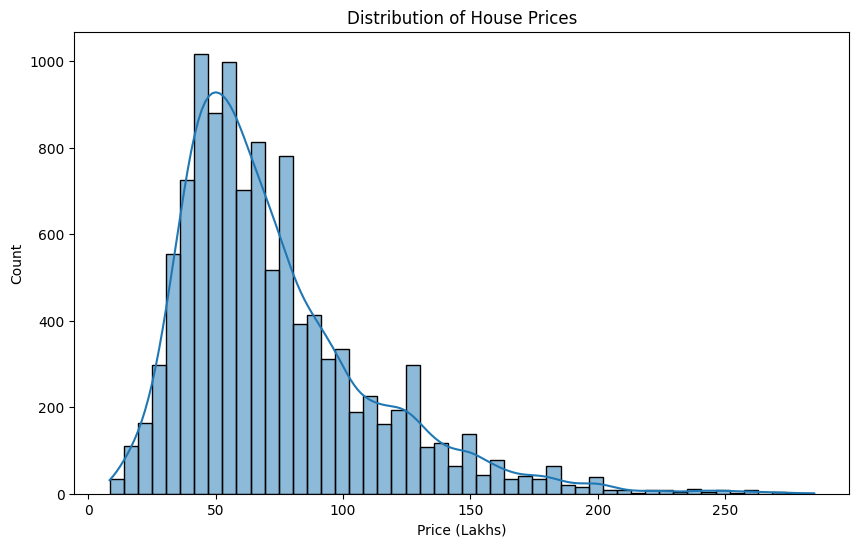

In [13]:
# Visualize price distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price (Lakhs)')
plt.ylabel('Count')
plt.show()

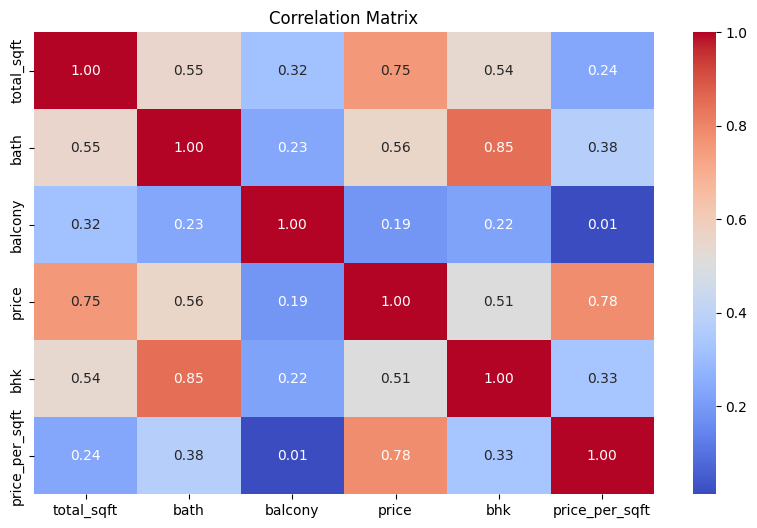

In [14]:
# Correlation matrix
plt.figure(figsize=(10, 6))
numeric_cols = data.select_dtypes(include=[np.number]).columns
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

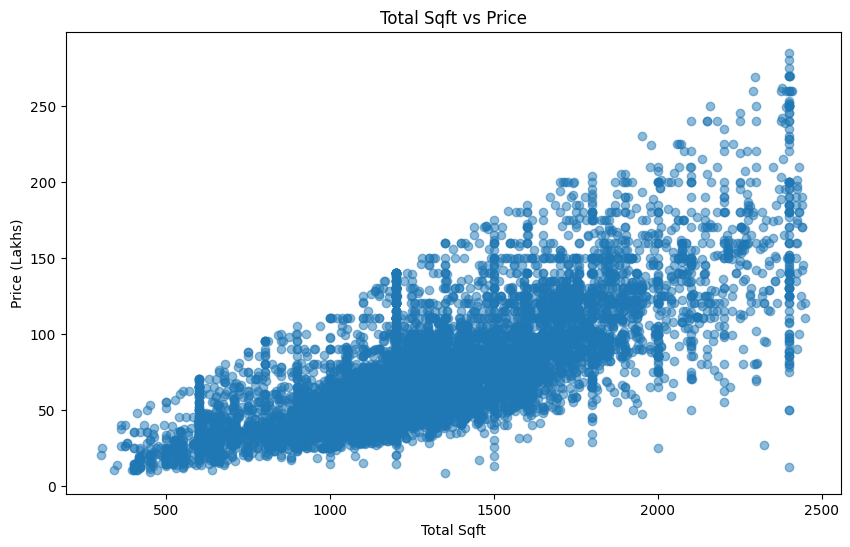

In [15]:
# Scatter plot: Total sqft vs Price
plt.figure(figsize=(10, 6))
plt.scatter(data['total_sqft'], data['price'], alpha=0.5)
plt.title('Total Sqft vs Price')
plt.xlabel('Total Sqft')
plt.ylabel('Price (Lakhs)')
plt.show()

In [16]:
# Select features for modeling
features = ['total_sqft', 'bath', 'balcony', 'bhk']
X = data[features]
y = data['price']

In [17]:
# Frequency encoding for location
location_freq = data['location'].value_counts().to_dict()
data['location_encoded'] = data['location'].map(location_freq)
X = X.assign(location_encoded=data['location_encoded'])

print("\nSelected features:", X.columns.tolist())


Selected features: ['total_sqft', 'bath', 'balcony', 'bhk', 'location_encoded']


In [18]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (8788, 5)
Testing set shape: (2198, 5)


In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled successfully!")

Features scaled successfully!


In [20]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

In [21]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
print("Models trained successfully!")

Models trained successfully!


In [22]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.2f} Lakhs")
    print(f"R² Score: {r2:.2f}")

In [23]:
# Evaluate both models
evaluate_model(y_test, lr_pred, "Linear Regression")
evaluate_model(y_test, rf_pred, "Random Forest")


Linear Regression Performance:
RMSE: 23.19 Lakhs
R² Score: 0.62

Random Forest Performance:
RMSE: 21.62 Lakhs
R² Score: 0.67


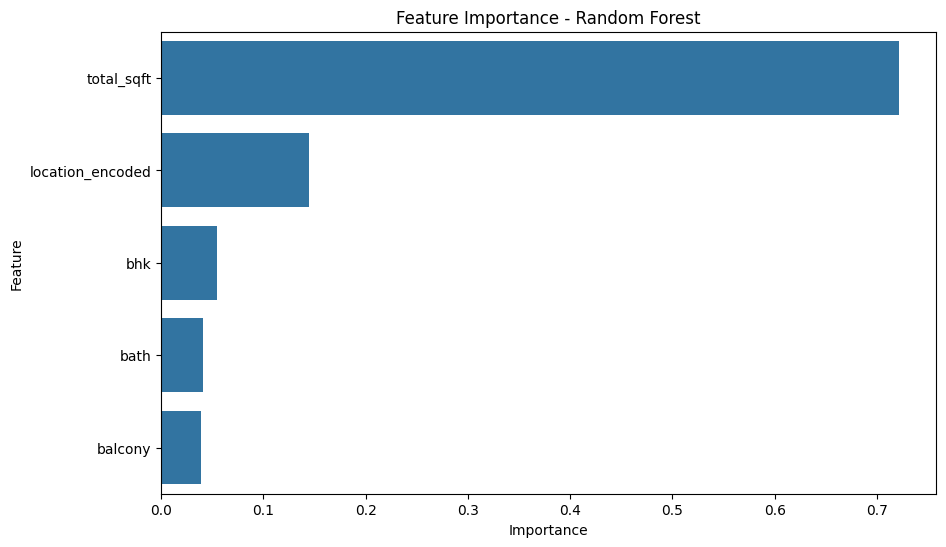

In [24]:
# Plot feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [25]:
# Function to predict house price
def predict_price(total_sqft, bath, balcony, bhk, location, model, scaler, location_freq):
    location_encoded = location_freq.get(location, min(location_freq.values()))
    input_data = np.array([[total_sqft, bath, balcony, bhk, location_encoded]])
    input_scaled = scaler.transform(input_data)
    return model.predict(input_scaled)[0]

In [26]:
# Example prediction
sample_location = data['location'].mode()[0]
predicted_price = predict_price(1000, 2, 1, 2, sample_location, rf_model, scaler, location_freq)
print(f"\nPredicted price for a 1000 sqft, 2 BHK, 2 bath, 1 balcony house in {sample_location}: {predicted_price:.2f} Lakhs")


Predicted price for a 1000 sqft, 2 BHK, 2 bath, 1 balcony house in Whitefield: 52.79 Lakhs


In [27]:
# Save the Random Forest model and scaler
import joblib
joblib.dump(rf_model, 'house_price_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Models and scaler saved successfully!")

Models and scaler saved successfully!
